In [1]:
import pandas as pd
import numpy as np

Below To Querery From MongoDB

In [2]:
"""
#Use script to upload CSV to mongodb

from pymongo import MongoClient
client = MongoClient('localhost', 27017)
client.list_database_names()
startups = client['startups']
res = startups['sf_startups'].find()
res_list = [item for item in res]
df = pd.DataFrame(res_list)
"""


"\n#Use script to upload CSV to mongodb\n\nfrom pymongo import MongoClient\nclient = MongoClient('localhost', 27017)\nclient.list_database_names()\nstartups = client['startups']\nres = startups['sf_startups'].find()\nres_list = [item for item in res]\ndf = pd.DataFrame(res_list)\n"

In [3]:
sf_all_df = pd.read_csv("startups_sf_2004-14_data.csv")

In [4]:
sf_companies = sf_all_df.fillna(0)[["company_name","company_market","company_city","company_category_list","company_city"]].drop_duplicates()

In [5]:
sf_companies = sf_companies.reset_index(drop=True)

In [6]:
import pickle 

with open('investor_rating_dict.pickle', 'rb') as handle:
    investor_rating_dict = pickle.load(handle)
    
with open('funding_dict.pickle', 'rb') as handle:
    funding_dict = pickle.load(handle)
    
with open('max_rounds_dict.pickle', 'rb') as handle:
    max_rounds_dict = pickle.load(handle)

In [7]:
sf_companies["total_funding"] = sf_companies["company_name"].map(funding_dict)

In [8]:
sf_companies["investor_rating"] = sf_companies["company_name"].map(investor_rating_dict)

In [9]:
sf_companies["company_max_round"] = sf_companies["company_name"].map(max_rounds_dict)

In [10]:
sf_companies[sf_companies["company_name"]=="Tesla Motors"]

,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round
17,Tesla Motors,Automotive,Palo Alto,|Automotive|,Palo Alto,823.0,9.852941,6.0


In [11]:
df = sf_companies.fillna(0)
print(df.shape)
df.head()

(4589, 8)


,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round
0,VirtualLogix,Software,Sunnyvale,|Mobile|Virtualization|Software|,Sunnyvale,29.288979,10.000000,2.0
1,Deem,E-Commerce,San Francisco,|Trading|Marketplaces|Content Syndication|Prod...,San Francisco,516.905435,9.821429,8.0
2,Pandora Media,Broadcasting,Oakland,|Broadcasting|Video Streaming|Music|,Oakland,56.300000,9.727273,4.0
3,PlayFirst,Games,San Francisco,|iPhone|Mobile Games|Games|,San Francisco,37.720000,10.000000,3.0
4,Socialtext,Enterprise Software,Palo Alto,|Collaboration|Software|Networking|Web Tools|E...,Palo Alto,46.770000,9.818182,4.0


## EDA Most Common Words

In [12]:
import matplotlib.pyplot as plt

In [13]:
keywords = df['company_category_list'].map(lambda x: str(x).lower().split("|"))
keywords = [item for sublist in keywords for item in sublist]

from collections import Counter
common_words = Counter(keywords).most_common(30)\

In [14]:
common_words.pop(0)

('', 9067)

Text(0.5,1,'Most Common Words in Category List')

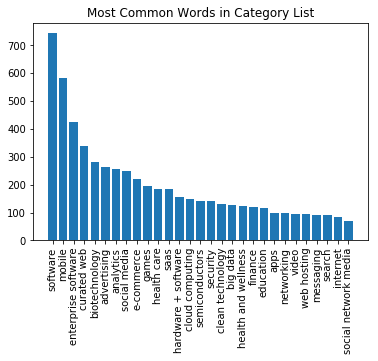

In [15]:
x = [w[0] for w in common_words]
y = [w[1] for w in common_words]

plt.bar(x,y)
plt.xticks(rotation=90);
plt.title("Most Common Words in Category List")

## Function to cluster dataframe

In [16]:
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn import preprocessing


def clustify(df, k_keywords, k_nums):
    
    """
    params: df = dataframe of startups
            k_keywords = number of clusters for keywords in category list
            k_nums = number of clusters for all the numerical features
            
    description: This function cleans and vectorizes the company_category_list. It is then clustered 
                 and added to the dataframe as feature for the overall cluster. The numerical features 
                 are copied to X_prescaling which is scaled before the final clustering.
    
    returns: The dataframe with the clusters are features
    """

    X_keyword = df['company_category_list'].map(lambda x: ' '.join(str(x).lower().split("|")))
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X_keyword)

    model = KMeans(n_clusters=k_keywords, init='k-means++', max_iter=100, n_init=1)
    keyword_clusters = model.fit_predict(X_vectorized)
    
       
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(k_keywords):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :5]:
            print(' %s' % terms[ind]),
        print
    
    
    keyword_cluster_dict = dict(zip(list(df['company_name']),keyword_clusters))
    df['keyword_clusters'] = df['company_name'].map(keyword_cluster_dict)
    
    #Cluster the already keyword clustered data
    X_prescaling = df[['total_funding','company_max_round','investor_rating']]
    X_prescaling.fillna(0)
    X_scaled  = pd.DataFrame(preprocessing.scale(X_prescaling))
    X_scaled['company_name'] = df['company_name']
    X_scaled['keyword_clusters'] = df['keyword_clusters']
    

    num_clust = KMeans(n_clusters=k_nums)
    num_clusters = num_clust.fit_predict(X_scaled[[0,'keyword_clusters']])   
    
    df['final_cluster'] = num_clusters
    
    return (df)


Choose K for clusters
-> selecting 30

In [17]:
range_n_clusters = list(range(2,50))
scores = []              
for n_clusters in range_n_clusters:

    X_keyword = df['company_category_list'].map(lambda x: ' '.join(str(x).lower().split("|")))
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X_keyword)

    model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1)

    cluster_labels = model.fit_predict(X_vectorized)

    silhouette_avg = silhouette_score(X_vectorized, cluster_labels)
    scores.append(silhouette_avg)
    #print("For n_clusters =", n_clusters,
    #      "The average silhouette_score is :", silhouette_avg)

Text(0,0.5,'Silhouette Score')

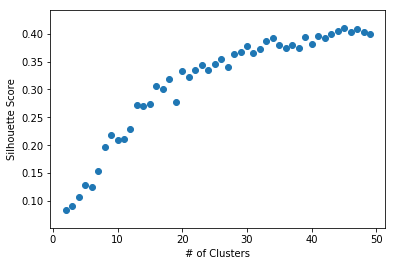

In [18]:
plt.scatter(list(range(2,50)),scores)
plt.xlabel("# of Clusters")
plt.ylabel("Silhouette Score")

In [19]:
clustered_df = clustify(df,30,100)
clustered_df

Top terms per cluster:
Cluster 0:
 care
 health
 biotechnology
 medical
 devices
Cluster 1:
 enterprise
 software
 storage
 saas
 internet
Cluster 2:
 biotechnology
 medical
 analytics
 nanotechnology
 technology
Cluster 3:
 games
 mobile
 social
 facebook
 applications
Cluster 4:
 semiconductors
 technology
 mobile
 computers
 electronics
Cluster 5:
 mobile
 commerce
 apps
 android
 devices
Cluster 6:
 software
 worlds
 design
 extensions
 experience
Cluster 7:
 social
 media
 commerce
 network
 marketing
Cluster 8:
 advertising
 mobile
 platforms
 analytics
 media
Cluster 9:
 curated
 web
 finance
 databases
 mobile
Cluster 10:
 hardware
 software
 video
 television
 mobile
Cluster 11:
 clean
 technology
 software
 energy
 semiconductors
Cluster 12:
 security
 mobile
 cloud
 data
 software
Cluster 13:
 analytics
 data
 big
 software
 predictive
Cluster 14:
 finance
 personal
 technology
 saas
 credit
Cluster 15:
 travel
 hotels
 media
 social
 search
Cluster 16:
 music
 mobile
 video

,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round,keyword_clusters,final_cluster
0,VirtualLogix,Software,Sunnyvale,|Mobile|Virtualization|Software|,Sunnyvale,29.288979,10.000000,2.0,22,94
1,Deem,E-Commerce,San Francisco,|Trading|Marketplaces|Content Syndication|Prod...,San Francisco,516.905435,9.821429,8.0,21,25
2,Pandora Media,Broadcasting,Oakland,|Broadcasting|Video Streaming|Music|,Oakland,56.300000,9.727273,4.0,27,38
3,PlayFirst,Games,San Francisco,|iPhone|Mobile Games|Games|,San Francisco,37.720000,10.000000,3.0,3,29
4,Socialtext,Enterprise Software,Palo Alto,|Collaboration|Software|Networking|Web Tools|E...,Palo Alto,46.770000,9.818182,4.0,26,4
5,SideStep,Hotels,Santa Clara,|Ticketing|Hotels|Travel|,Santa Clara,32.000000,10.000000,3.0,15,41
6,Soundflavor,Music,San Francisco,|Ediscovery|Music|,San Francisco,5.800000,7.400000,1.0,16,16
7,Executive Caddie,iPhone,Mountain View,|Windows Phone 7|iPhone|Sports|Software|,Mountain View,3.000000,6.000000,0.0,22,9
8,VisualOn,Software,San Jose,|Software|,San Jose,2.700000,7.500000,2.0,6,1
9,Innovative Silicon,Semiconductors,Santa Clara,|Semiconductors|,Santa Clara,72.000000,10.000000,3.0,4,75


In [20]:
def check_cluster_sizes(value_counts):
    list_ = list(zip(value_counts.keys(),value_counts.values))
    return(list_)

In [21]:
print("(Cluster number, Amount in cluster)")
print("-------")
print(check_cluster_sizes(clustered_df['final_cluster'].value_counts()))

(Cluster number, Amount in cluster)
-------
[(9, 737), (1, 282), (88, 225), (94, 188), (6, 172), (46, 139), (39, 138), (13, 127), (47, 125), (29, 117), (5, 114), (61, 105), (63, 99), (23, 95), (14, 84), (67, 82), (21, 79), (8, 76), (33, 71), (20, 70), (18, 67), (32, 66), (3, 63), (62, 62), (84, 59), (27, 58), (12, 58), (87, 58), (17, 49), (80, 48), (16, 47), (22, 45), (75, 45), (31, 44), (0, 43), (41, 41), (28, 36), (55, 34), (99, 33), (49, 32), (11, 28), (2, 28), (56, 28), (73, 23), (38, 22), (66, 20), (71, 19), (72, 19), (70, 18), (93, 17), (58, 15), (98, 13), (51, 13), (89, 13), (64, 13), (4, 12), (82, 11), (77, 10), (78, 10), (43, 9), (45, 9), (97, 9), (57, 8), (40, 8), (79, 7), (52, 6), (92, 6), (24, 6), (42, 6), (50, 6), (35, 5), (25, 4), (68, 4), (65, 4), (91, 3), (44, 3), (95, 3), (81, 3), (86, 3), (19, 3), (7, 3), (74, 3), (59, 2), (15, 2), (76, 2), (36, 2), (54, 2), (34, 1), (37, 1), (83, 1), (30, 1), (26, 1), (10, 1), (48, 1), (85, 1), (90, 1), (96, 1), (53, 1), (69, 1), (60

In [22]:
#clustered_df.to_csv('clustered_df.csv',sep=',',index=False)

In [23]:
def showTopCompanies(df, enteredCompany):
    
    """
    params: df = dataframe of startups
            enteredCompany = company of name of interest 
            
    description: Filters the dataframe to show companies within the same cluster as the comapny of interest
    
    returns: dashboard and the clustered companies
            
    """
    
    company_data = df[df["company_name"]==enteredCompany]
    cluster_group = company_data.iloc[0]['final_cluster']    
    group = df[df['final_cluster']==cluster_group]
    
    fig = dashboard(group, enteredCompany)
    plot(fig, filename='name.html', auto_open=False)
    
    return fig, group

In [24]:
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

def dashboard(df_plt, company_name):
    
    """
    params: df_plt = dataframe to be plotted
            company_name = startup of interest
            
    description: creates subplots to display various metrics of companies that were clustered together.
    
    returns: displays a figure with subplots and the object is returned as well. 
    """
    
    searched_df = df_plt[df_plt['company_name'] == company_name]
    similar_df = df_plt[df_plt['company_name'] != company_name]
    
    '''
    #Plotly doesn't support tables subplot, needs to be removed for subplot
    trace1 = go.Table(
        header=dict(values=[1,2],
                    #fill = dict(color='#C2D4FF'),
                    align = ['left'] * 5),
        cells=dict(values=[1,2],
                   #fill = dict(color='#F5F8FF'),
                   align = ['left'] * 5)
    )
    '''
    
    trace2 = go.Bar(
        x=[x for x in searched_df['company_name']] + [x for x in similar_df['company_name']],
        y=list(searched_df['total_funding']) + list(similar_df['total_funding']),
        #text=['Text A', 'Text B', 'Text C'],
    )
    
    trace3 = go.Bar(
        name='Test',
        x=[x for x in searched_df['company_name']] + [x for x in similar_df['company_name']],
        y=list(searched_df['company_max_round']) + list(similar_df['company_max_round']),
        #text=['Text D', 'Text E', 'Text F'],
    )
    
    trace4 = go.Bar(
        name='Test',
        x=[x for x in searched_df['company_name']] + [x for x in similar_df['company_name']],
        y=list(searched_df['investor_rating']) + list(similar_df['investor_rating']),
        #text=['Text D', 'Text E', 'Text F'],
    )
    
    fig = tools.make_subplots(rows=2, cols=3,subplot_titles=('Total Funding', 'Rounds','Investor Rating'))

    #fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 2)
    fig.append_trace(trace4, 1, 3)


    fig['layout'].update(height=600, width=800,showlegend = False, title=f'Companies Similar To *{company_name}*')
    #py.iplot(fig, filename='simple-subplot-with-annotations')
    iplot(fig,filename='basic')
    
    return fig

In [32]:
fig, group = showTopCompanies(clustered_df, 'Tesla Motors')
group

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round,keyword_clusters,final_cluster
17,Tesla Motors,Automotive,Palo Alto,|Automotive|,Palo Alto,823.0,9.852941,6.0,22,15
2154,SurveyMonkey,Software,Palo Alto,|Surveys|Software|,Palo Alto,900.0,10.000000,0.0,22,15


In [27]:
#Code Is Deployed In Web App. See App Folder